In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=5,n=2)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

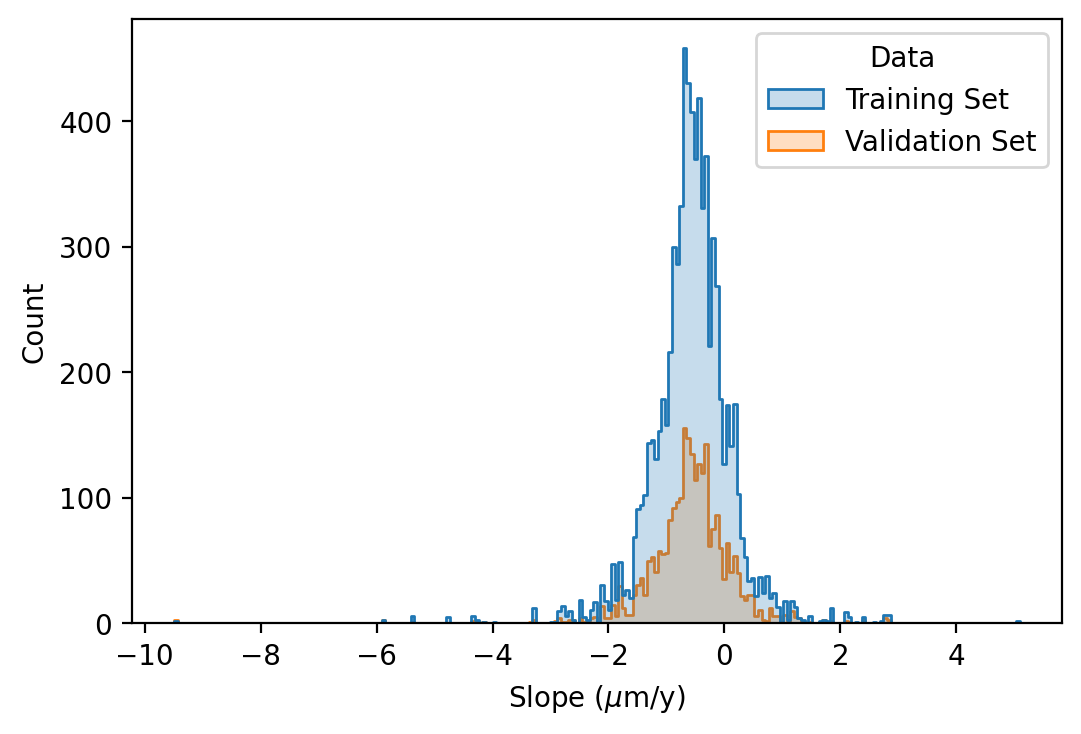

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

7759 2586


In [6]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1
print(ts)

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[120], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

5


In [7]:
epochs = 200
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        torch.save(model.state_dict(),'state_dict_ts5.pt')
        #best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/200]: 100%|██████████| 122/122 [00:31<00:00,  3.82it/s, batch_loss=0.323, running_loss=62.5]


Train Loss: 62.5223 | Valid Loss: inf ===========> 24.7403 | Test Loss: 21.2213 | Saving model...


Epoch [2/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.247, running_loss=61.3]


Train Loss: 61.3303 | Valid Loss: 25.3604


Epoch [3/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.286, running_loss=60.9]


Train Loss: 60.8977 | Valid Loss: 25.8074


Epoch [4/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.441, running_loss=60.3]


Train Loss: 60.2865 | Valid Loss: 24.8499


Epoch [5/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.255, running_loss=59.3]


Train Loss: 59.2860 | Valid Loss: 24.7403 ===========> 23.6896 | Test Loss: 20.4066 | Saving model...


Epoch [6/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.828, running_loss=58.7]


Train Loss: 58.6750 | Valid Loss: 36.7924


Epoch [7/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.785, running_loss=57.5]


Train Loss: 57.4811 | Valid Loss: 29.3068


Epoch [8/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.309, running_loss=55]


Train Loss: 54.9906 | Valid Loss: 23.9797


Epoch [9/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=1.59, running_loss=53.7]


Train Loss: 53.7378 | Valid Loss: 56.2927


Epoch [10/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.749, running_loss=52.1]


Train Loss: 52.0720 | Valid Loss: 25.8380


Epoch [11/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.824, running_loss=49.8]


Train Loss: 49.7991 | Valid Loss: 23.6896 ===========> 22.6346 | Test Loss: 21.3517 | Saving model...


Epoch [12/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=1.17, running_loss=46.9]


Train Loss: 46.9340 | Valid Loss: 87.1731


Epoch [13/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.442, running_loss=45.2]


Train Loss: 45.1595 | Valid Loss: 22.6346 ===========> 21.7538 | Test Loss: 19.2625 | Saving model...


Epoch [14/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.281, running_loss=41.7]


Train Loss: 41.7289 | Valid Loss: 21.7538 ===========> 21.2275 | Test Loss: 18.3640 | Saving model...


Epoch [15/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.53, running_loss=37.1]


Train Loss: 37.0932 | Valid Loss: 21.3061


Epoch [16/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.4, running_loss=33.8]


Train Loss: 33.7976 | Valid Loss: 23.3632


Epoch [17/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.184, running_loss=32.7]


Train Loss: 32.6649 | Valid Loss: 21.6251


Epoch [18/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.218, running_loss=28.4]


Train Loss: 28.3800 | Valid Loss: 22.3955


Epoch [19/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0874, running_loss=26.4]


Train Loss: 26.3631 | Valid Loss: 21.2275 ===========> 19.5441 | Test Loss: 17.1954 | Saving model...


Epoch [20/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.338, running_loss=24.1]


Train Loss: 24.0507 | Valid Loss: 20.7886


Epoch [21/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.18, running_loss=19.2]


Train Loss: 19.1698 | Valid Loss: 29.9601


Epoch [22/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0513, running_loss=17.4]


Train Loss: 17.3844 | Valid Loss: 19.5441 ===========> 18.0491 | Test Loss: 15.4737 | Saving model...


Epoch [23/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0961, running_loss=15.3]


Train Loss: 15.2570 | Valid Loss: 21.3679


Epoch [24/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0535, running_loss=12.8]


Train Loss: 12.7635 | Valid Loss: 18.7406


Epoch [25/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0877, running_loss=12.2]


Train Loss: 12.1808 | Valid Loss: 18.2855


Epoch [26/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0342, running_loss=11]


Train Loss: 10.9506 | Valid Loss: 18.9345


Epoch [27/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0706, running_loss=9.25]


Train Loss: 9.2502 | Valid Loss: 18.0491 ===========> 17.7066 | Test Loss: 15.3136 | Saving model...


Epoch [28/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0314, running_loss=7.79]


Train Loss: 7.7945 | Valid Loss: 17.7066 ===========> 17.3381 | Test Loss: 14.7933 | Saving model...


Epoch [29/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0488, running_loss=7.88]


Train Loss: 7.8814 | Valid Loss: 17.3381 ===========> 17.1119 | Test Loss: 14.9030 | Saving model...


Epoch [30/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0372, running_loss=6.95]


Train Loss: 6.9543 | Valid Loss: 17.1119 ===========> 17.1106 | Test Loss: 14.4299 | Saving model...


Epoch [31/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0229, running_loss=5.71]


Train Loss: 5.7082 | Valid Loss: 17.1106 ===========> 16.6420 | Test Loss: 14.6345 | Saving model...


Epoch [32/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0419, running_loss=5.72]


Train Loss: 5.7222 | Valid Loss: 17.2021


Epoch [33/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0722, running_loss=5.88]


Train Loss: 5.8822 | Valid Loss: 16.8518


Epoch [34/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0494, running_loss=5.01]


Train Loss: 5.0135 | Valid Loss: 17.2514


Epoch [35/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0284, running_loss=4.49]


Train Loss: 4.4898 | Valid Loss: 16.6420 ===========> 16.3860 | Test Loss: 14.2016 | Saving model...


Epoch [36/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0431, running_loss=4.74]


Train Loss: 4.7440 | Valid Loss: 17.8881


Epoch [37/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0362, running_loss=3.98]


Train Loss: 3.9754 | Valid Loss: 17.7711


Epoch [38/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0394, running_loss=3.59]


Train Loss: 3.5888 | Valid Loss: 16.3860 ===========> 16.2257 | Test Loss: 14.3037 | Saving model...


Epoch [39/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.00889, running_loss=3.54]


Train Loss: 3.5408 | Valid Loss: 16.2257 ===========> 16.1238 | Test Loss: 13.9930 | Saving model...


Epoch [40/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0378, running_loss=3.27]


Train Loss: 3.2724 | Valid Loss: 16.7598


Epoch [41/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.028, running_loss=3.66]


Train Loss: 3.6613 | Valid Loss: 16.1499


Epoch [42/200]: 100%|██████████| 122/122 [00:31<00:00,  3.88it/s, batch_loss=0.0399, running_loss=3.37]


Train Loss: 3.3718 | Valid Loss: 17.4439


Epoch [43/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0478, running_loss=3.14]


Train Loss: 3.1399 | Valid Loss: 17.8944


Epoch [44/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0207, running_loss=3.12]


Train Loss: 3.1209 | Valid Loss: 16.4169


Epoch [45/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0323, running_loss=3.06]


Train Loss: 3.0567 | Valid Loss: 17.2650


Epoch [46/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.00854, running_loss=3.05]


Train Loss: 3.0516 | Valid Loss: 16.1238 ===========> 16.0427 | Test Loss: 13.6555 | Saving model...


Epoch [47/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0223, running_loss=2.82]


Train Loss: 2.8228 | Valid Loss: 17.0033


Epoch [48/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0252, running_loss=2.88]


Train Loss: 2.8836 | Valid Loss: 16.2722


Epoch [49/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0585, running_loss=2.77]


Train Loss: 2.7700 | Valid Loss: 16.5872


Epoch [50/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.015, running_loss=2.78]


Train Loss: 2.7764 | Valid Loss: 16.0476


Epoch [51/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0199, running_loss=2.47]


Train Loss: 2.4724 | Valid Loss: 16.0427 ===========> 16.0379 | Test Loss: 14.1193 | Saving model...


Epoch [52/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0205, running_loss=2.39]


Train Loss: 2.3858 | Valid Loss: 16.1805


Epoch [53/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0467, running_loss=2.3]


Train Loss: 2.3026 | Valid Loss: 16.8908


Epoch [54/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0358, running_loss=2.34]


Train Loss: 2.3432 | Valid Loss: 16.1639


Epoch [55/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0319, running_loss=2.38]


Train Loss: 2.3828 | Valid Loss: 16.0379 ===========> 16.0056 | Test Loss: 13.8429 | Saving model...


Epoch [56/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0108, running_loss=2.33]


Train Loss: 2.3296 | Valid Loss: 16.0476


Epoch [57/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.03, running_loss=2.32]


Train Loss: 2.3169 | Valid Loss: 16.0056 ===========> 15.8873 | Test Loss: 13.5568 | Saving model...


Epoch [58/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0324, running_loss=2.16]


Train Loss: 2.1586 | Valid Loss: 17.0979


Epoch [59/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0132, running_loss=2.27]


Train Loss: 2.2682 | Valid Loss: 15.8873 ===========> 15.8866 | Test Loss: 13.8384 | Saving model...


Epoch [60/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.028, running_loss=2.31]


Train Loss: 2.3071 | Valid Loss: 16.5794


Epoch [61/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0152, running_loss=2.11]


Train Loss: 2.1119 | Valid Loss: 16.3595


Epoch [62/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.012, running_loss=1.97]


Train Loss: 1.9702 | Valid Loss: 15.9189


Epoch [63/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0196, running_loss=2.02]


Train Loss: 2.0219 | Valid Loss: 16.3051


Epoch [64/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0106, running_loss=2]


Train Loss: 2.0041 | Valid Loss: 16.0764


Epoch [65/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0267, running_loss=2.04]


Train Loss: 2.0402 | Valid Loss: 16.4168


Epoch [66/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0217, running_loss=2.11]


Train Loss: 2.1062 | Valid Loss: 15.8978


Epoch [67/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0322, running_loss=1.91]


Train Loss: 1.9051 | Valid Loss: 15.9428


Epoch [68/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0108, running_loss=1.91]


Train Loss: 1.9067 | Valid Loss: 15.8866 ===========> 15.8528 | Test Loss: 13.4975 | Saving model...


Epoch [69/200]: 100%|██████████| 122/122 [00:31<00:00,  3.85it/s, batch_loss=0.0208, running_loss=1.91]


Train Loss: 1.9133 | Valid Loss: 16.0838


Epoch [70/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0181, running_loss=1.84]


Train Loss: 1.8424 | Valid Loss: 16.0005


Epoch [71/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0187, running_loss=1.79]


Train Loss: 1.7924 | Valid Loss: 16.0505


Epoch [72/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.00829, running_loss=1.78]


Train Loss: 1.7818 | Valid Loss: 16.0841


Epoch [73/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0119, running_loss=1.69]


Train Loss: 1.6855 | Valid Loss: 15.9978


Epoch [74/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.00815, running_loss=1.64]


Train Loss: 1.6424 | Valid Loss: 15.8528 ===========> 15.7925 | Test Loss: 13.4032 | Saving model...


Epoch [75/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.0422, running_loss=1.6]


Train Loss: 1.6033 | Valid Loss: 15.7925 ===========> 15.6264 | Test Loss: 13.4673 | Saving model...


Epoch [76/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.00927, running_loss=1.74]


Train Loss: 1.7373 | Valid Loss: 16.2759


Epoch [77/200]: 100%|██████████| 122/122 [00:31<00:00,  3.86it/s, batch_loss=0.00639, running_loss=1.65]


Train Loss: 1.6543 | Valid Loss: 15.8352


Epoch [78/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.0104, running_loss=1.6]


Train Loss: 1.5987 | Valid Loss: 15.9562


Epoch [79/200]: 100%|██████████| 122/122 [00:31<00:00,  3.87it/s, batch_loss=0.008, running_loss=1.63]


Train Loss: 1.6325 | Valid Loss: 15.8555


Epoch [80/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0284, running_loss=1.62]


Train Loss: 1.6240 | Valid Loss: 15.8829


Epoch [81/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0135, running_loss=1.59]


Train Loss: 1.5867 | Valid Loss: 16.4594


Epoch [82/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0104, running_loss=1.54]


Train Loss: 1.5381 | Valid Loss: 15.7665


Epoch [83/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00859, running_loss=1.55]


Train Loss: 1.5466 | Valid Loss: 15.7015


Epoch [84/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0296, running_loss=1.51]


Train Loss: 1.5089 | Valid Loss: 16.1590


Epoch [85/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0303, running_loss=1.56]


Train Loss: 1.5574 | Valid Loss: 16.3210


Epoch [86/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0382, running_loss=1.56]


Train Loss: 1.5584 | Valid Loss: 16.3631


Epoch [87/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00809, running_loss=1.57]


Train Loss: 1.5720 | Valid Loss: 15.7232


Epoch [88/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0153, running_loss=1.44]


Train Loss: 1.4425 | Valid Loss: 15.7269


Epoch [89/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.019, running_loss=1.36]


Train Loss: 1.3610 | Valid Loss: 15.7607


Epoch [90/200]: 100%|██████████| 122/122 [00:30<00:00,  3.94it/s, batch_loss=0.00894, running_loss=1.41]


Train Loss: 1.4134 | Valid Loss: 15.8726


Epoch [91/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0205, running_loss=1.41]


Train Loss: 1.4067 | Valid Loss: 15.6308


Epoch [92/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0156, running_loss=1.41]


Train Loss: 1.4132 | Valid Loss: 15.6264 ===========> 15.5425 | Test Loss: 13.5323 | Saving model...


Epoch [93/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0122, running_loss=1.38]


Train Loss: 1.3823 | Valid Loss: 15.8417


Epoch [94/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0103, running_loss=1.42]


Train Loss: 1.4163 | Valid Loss: 15.7930


Epoch [95/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00822, running_loss=1.35]


Train Loss: 1.3546 | Valid Loss: 15.7872


Epoch [96/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0112, running_loss=1.39]


Train Loss: 1.3887 | Valid Loss: 16.0449


Epoch [97/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00879, running_loss=1.35]


Train Loss: 1.3518 | Valid Loss: 15.6875


Epoch [98/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0082, running_loss=1.34]


Train Loss: 1.3367 | Valid Loss: 15.6516


Epoch [99/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0158, running_loss=1.33]


Train Loss: 1.3279 | Valid Loss: 15.7622


Epoch [100/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0191, running_loss=1.36]


Train Loss: 1.3631 | Valid Loss: 15.5425 ===========> 15.4200 | Test Loss: 13.2813 | Saving model...


Epoch [101/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0199, running_loss=1.36]


Train Loss: 1.3568 | Valid Loss: 16.2588


Epoch [102/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00814, running_loss=1.32]


Train Loss: 1.3163 | Valid Loss: 15.5845


Epoch [103/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00949, running_loss=1.26]


Train Loss: 1.2556 | Valid Loss: 16.2914


Epoch [104/200]: 100%|██████████| 122/122 [00:31<00:00,  3.90it/s, batch_loss=0.00643, running_loss=1.27]


Train Loss: 1.2719 | Valid Loss: 15.6578


Epoch [105/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00965, running_loss=1.23]


Train Loss: 1.2273 | Valid Loss: 16.0857


Epoch [106/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.01, running_loss=1.2]


Train Loss: 1.1957 | Valid Loss: 15.6610


Epoch [107/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.032, running_loss=1.31]


Train Loss: 1.3065 | Valid Loss: 15.4614


Epoch [108/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00474, running_loss=1.27]


Train Loss: 1.2668 | Valid Loss: 15.7856


Epoch [109/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.013, running_loss=1.23]


Train Loss: 1.2340 | Valid Loss: 15.7156


Epoch [110/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0149, running_loss=1.23]


Train Loss: 1.2341 | Valid Loss: 15.9800


Epoch [111/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00847, running_loss=1.2]


Train Loss: 1.1960 | Valid Loss: 15.7078


Epoch [112/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.00746, running_loss=1.21]


Train Loss: 1.2069 | Valid Loss: 15.8489


Epoch [113/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00358, running_loss=1.18]


Train Loss: 1.1807 | Valid Loss: 15.5448


Epoch [114/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00678, running_loss=1.21]


Train Loss: 1.2128 | Valid Loss: 15.8029


Epoch [115/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00738, running_loss=1.23]


Train Loss: 1.2297 | Valid Loss: 15.8535


Epoch [116/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0259, running_loss=1.21]


Train Loss: 1.2134 | Valid Loss: 15.5999


Epoch [117/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00705, running_loss=1.22]


Train Loss: 1.2164 | Valid Loss: 15.6825


Epoch [118/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0142, running_loss=1.14]


Train Loss: 1.1420 | Valid Loss: 16.2122


Epoch [119/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0238, running_loss=1.22]


Train Loss: 1.2214 | Valid Loss: 15.5068


Epoch [120/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00591, running_loss=1.18]


Train Loss: 1.1789 | Valid Loss: 15.6496


Epoch [121/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00396, running_loss=1.11]


Train Loss: 1.1120 | Valid Loss: 16.0389


Epoch [122/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0136, running_loss=1.05]


Train Loss: 1.0474 | Valid Loss: 15.6909


Epoch [123/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0136, running_loss=1.03]


Train Loss: 1.0317 | Valid Loss: 15.7045


Epoch [124/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0247, running_loss=1.05]


Train Loss: 1.0468 | Valid Loss: 15.6752


Epoch [125/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0132, running_loss=1.02]


Train Loss: 1.0177 | Valid Loss: 15.5941


Epoch [126/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.00902, running_loss=1.02]


Train Loss: 1.0164 | Valid Loss: 15.6268


Epoch [127/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0145, running_loss=1.02]


Train Loss: 1.0208 | Valid Loss: 15.6254


Epoch [128/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0208, running_loss=0.981]


Train Loss: 0.9809 | Valid Loss: 15.6514


Epoch [129/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0171, running_loss=1]


Train Loss: 1.0013 | Valid Loss: 15.6289


Epoch [130/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00762, running_loss=0.999]


Train Loss: 0.9987 | Valid Loss: 15.6385


Epoch [131/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00482, running_loss=0.948]


Train Loss: 0.9482 | Valid Loss: 15.5598


Epoch [132/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0204, running_loss=0.959]


Train Loss: 0.9595 | Valid Loss: 15.5886


Epoch [133/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0156, running_loss=0.982]


Train Loss: 0.9825 | Valid Loss: 16.0654


Epoch [134/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0228, running_loss=0.952]


Train Loss: 0.9523 | Valid Loss: 15.5633


Epoch [135/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0137, running_loss=0.982]


Train Loss: 0.9823 | Valid Loss: 15.5775


Epoch [136/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0148, running_loss=0.968]


Train Loss: 0.9677 | Valid Loss: 15.6105


Epoch [137/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0194, running_loss=0.972]


Train Loss: 0.9725 | Valid Loss: 15.5345


Epoch [138/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.01, running_loss=0.953]


Train Loss: 0.9534 | Valid Loss: 15.7312


Epoch [139/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00731, running_loss=0.963]


Train Loss: 0.9633 | Valid Loss: 15.8776


Epoch [140/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00837, running_loss=0.919]


Train Loss: 0.9186 | Valid Loss: 15.7300


Epoch [141/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0101, running_loss=0.958]


Train Loss: 0.9579 | Valid Loss: 15.5446


Epoch [142/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0134, running_loss=0.951]


Train Loss: 0.9507 | Valid Loss: 15.5973


Epoch [143/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0233, running_loss=0.927]


Train Loss: 0.9271 | Valid Loss: 15.6275


Epoch [144/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00853, running_loss=0.919]


Train Loss: 0.9191 | Valid Loss: 15.5768


Epoch [145/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00932, running_loss=0.93]


Train Loss: 0.9301 | Valid Loss: 15.6188


Epoch [146/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00552, running_loss=0.938]


Train Loss: 0.9381 | Valid Loss: 15.5950


Epoch [147/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.008, running_loss=0.92]


Train Loss: 0.9204 | Valid Loss: 15.7631


Epoch [148/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00691, running_loss=0.895]


Train Loss: 0.8951 | Valid Loss: 15.6084


Epoch [149/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00541, running_loss=0.915]


Train Loss: 0.9149 | Valid Loss: 16.1070


Epoch [150/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00537, running_loss=0.921]


Train Loss: 0.9211 | Valid Loss: 15.5675


Epoch [151/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0056, running_loss=0.911]


Train Loss: 0.9110 | Valid Loss: 15.8074


Epoch [152/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0203, running_loss=0.916]


Train Loss: 0.9162 | Valid Loss: 15.5373


Epoch [153/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00385, running_loss=0.932]


Train Loss: 0.9316 | Valid Loss: 15.7372


Epoch [154/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0281, running_loss=0.901]


Train Loss: 0.9010 | Valid Loss: 15.7950


Epoch [155/200]: 100%|██████████| 122/122 [00:31<00:00,  3.90it/s, batch_loss=0.0118, running_loss=0.937]


Train Loss: 0.9374 | Valid Loss: 15.5450


Epoch [156/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00771, running_loss=0.905]


Train Loss: 0.9051 | Valid Loss: 16.3695


Epoch [157/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0073, running_loss=0.894]


Train Loss: 0.8937 | Valid Loss: 15.5443


Epoch [158/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0428, running_loss=0.941]


Train Loss: 0.9410 | Valid Loss: 15.4860


Epoch [159/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0104, running_loss=0.917]


Train Loss: 0.9166 | Valid Loss: 15.5703


Epoch [160/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0164, running_loss=0.915]


Train Loss: 0.9151 | Valid Loss: 15.6044


Epoch [161/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0118, running_loss=0.876]


Train Loss: 0.8756 | Valid Loss: 15.5449


Epoch [162/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00328, running_loss=0.904]


Train Loss: 0.9041 | Valid Loss: 15.6778


Epoch [163/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00922, running_loss=0.917]


Train Loss: 0.9175 | Valid Loss: 15.5708


Epoch [164/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.0154, running_loss=0.883]


Train Loss: 0.8826 | Valid Loss: 15.6449


Epoch [165/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0104, running_loss=0.905]


Train Loss: 0.9046 | Valid Loss: 15.4807


Epoch [166/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00964, running_loss=0.897]


Train Loss: 0.8971 | Valid Loss: 15.6171


Epoch [167/200]: 100%|██████████| 122/122 [00:31<00:00,  3.90it/s, batch_loss=0.0207, running_loss=0.874]


Train Loss: 0.8741 | Valid Loss: 16.0452


Epoch [168/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00866, running_loss=0.911]


Train Loss: 0.9113 | Valid Loss: 15.5116


Epoch [169/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00463, running_loss=0.87]


Train Loss: 0.8704 | Valid Loss: 15.5987


Epoch [170/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0141, running_loss=0.859]


Train Loss: 0.8593 | Valid Loss: 15.6429


Epoch [171/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00994, running_loss=0.918]


Train Loss: 0.9177 | Valid Loss: 15.5096


Epoch [172/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0126, running_loss=0.875]


Train Loss: 0.8747 | Valid Loss: 15.7191


Epoch [173/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0159, running_loss=0.859]


Train Loss: 0.8586 | Valid Loss: 15.5380


Epoch [174/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0207, running_loss=0.864]


Train Loss: 0.8635 | Valid Loss: 15.6058


Epoch [175/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00476, running_loss=0.875]


Train Loss: 0.8752 | Valid Loss: 15.5250


Epoch [176/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.034, running_loss=0.907]


Train Loss: 0.9068 | Valid Loss: 15.6227


Epoch [177/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00969, running_loss=0.912]


Train Loss: 0.9116 | Valid Loss: 15.7257


Epoch [178/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00493, running_loss=0.905]


Train Loss: 0.9050 | Valid Loss: 15.5752


Epoch [179/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00486, running_loss=0.889]


Train Loss: 0.8887 | Valid Loss: 15.6212


Epoch [180/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00999, running_loss=0.888]


Train Loss: 0.8885 | Valid Loss: 16.1196


Epoch [181/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00909, running_loss=0.874]


Train Loss: 0.8745 | Valid Loss: 15.5450


Epoch [182/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0178, running_loss=0.888]


Train Loss: 0.8876 | Valid Loss: 15.6218


Epoch [183/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0112, running_loss=0.869]


Train Loss: 0.8690 | Valid Loss: 15.6070


Epoch [184/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00447, running_loss=0.874]


Train Loss: 0.8737 | Valid Loss: 15.5255


Epoch [185/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00401, running_loss=0.865]


Train Loss: 0.8647 | Valid Loss: 15.5783


Epoch [186/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.00574, running_loss=0.859]


Train Loss: 0.8593 | Valid Loss: 15.6053


Epoch [187/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00978, running_loss=0.86]


Train Loss: 0.8603 | Valid Loss: 15.7988


Epoch [188/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00426, running_loss=0.848]


Train Loss: 0.8476 | Valid Loss: 15.6381


Epoch [189/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00473, running_loss=0.838]


Train Loss: 0.8383 | Valid Loss: 15.6192


Epoch [190/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00572, running_loss=0.888]


Train Loss: 0.8882 | Valid Loss: 15.5296


Epoch [191/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00707, running_loss=0.855]


Train Loss: 0.8548 | Valid Loss: 15.6460


Epoch [192/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0185, running_loss=0.87]


Train Loss: 0.8701 | Valid Loss: 15.5511


Epoch [193/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00635, running_loss=0.881]


Train Loss: 0.8814 | Valid Loss: 15.5263


Epoch [194/200]: 100%|██████████| 122/122 [00:31<00:00,  3.93it/s, batch_loss=0.00559, running_loss=0.893]


Train Loss: 0.8934 | Valid Loss: 15.8369


Epoch [195/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00599, running_loss=0.86]


Train Loss: 0.8600 | Valid Loss: 15.6131


Epoch [196/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.0157, running_loss=0.875]


Train Loss: 0.8746 | Valid Loss: 15.6185


Epoch [197/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.0492, running_loss=0.908]


Train Loss: 0.9078 | Valid Loss: 16.1191


Epoch [198/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.006, running_loss=0.88]


Train Loss: 0.8803 | Valid Loss: 15.5643


Epoch [199/200]: 100%|██████████| 122/122 [00:31<00:00,  3.92it/s, batch_loss=0.00617, running_loss=0.884]


Train Loss: 0.8837 | Valid Loss: 15.5220


Epoch [200/200]: 100%|██████████| 122/122 [00:31<00:00,  3.91it/s, batch_loss=0.00457, running_loss=0.892]


Train Loss: 0.8923 | Valid Loss: 15.5468


Train Loss: 1.3631 | Valid Loss: 15.4200 | Test Loss on Best Model: 13.2813


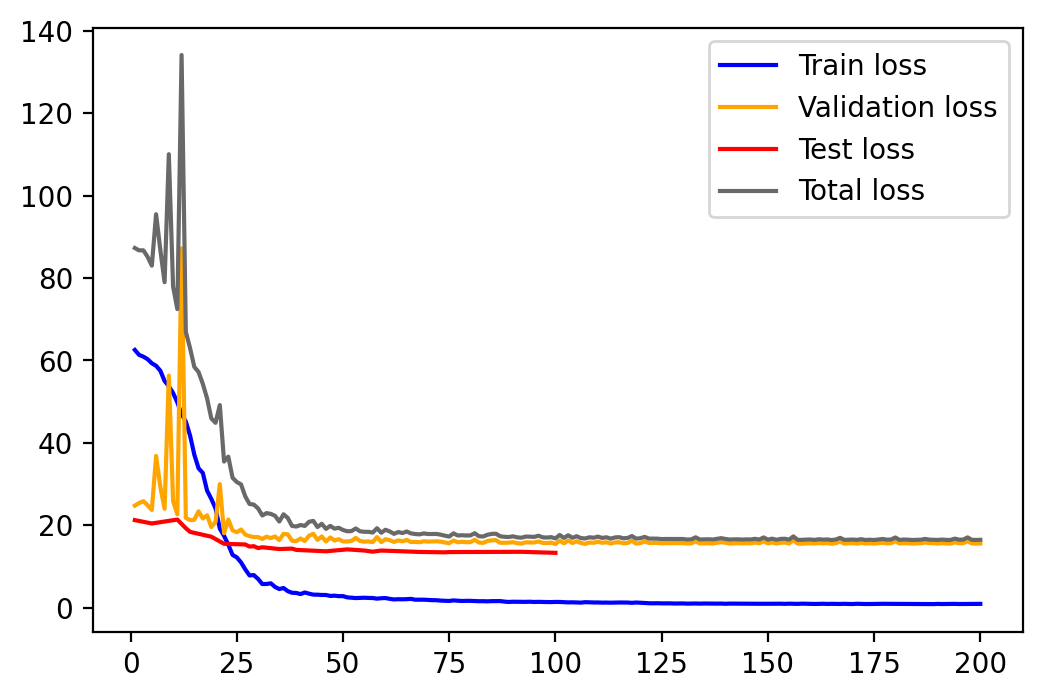

In [8]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [11]:
tsloss = 0
model.load_state_dict(torch.load('state_dict_ts5.pt'))
model.eval()
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


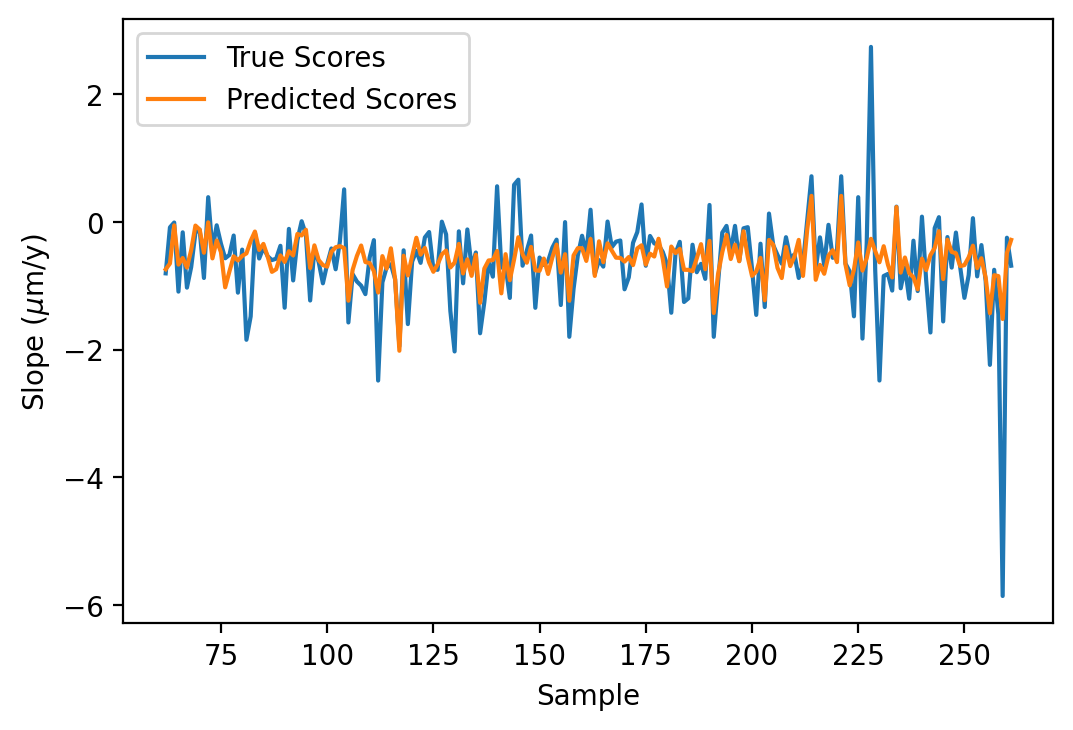

In [12]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

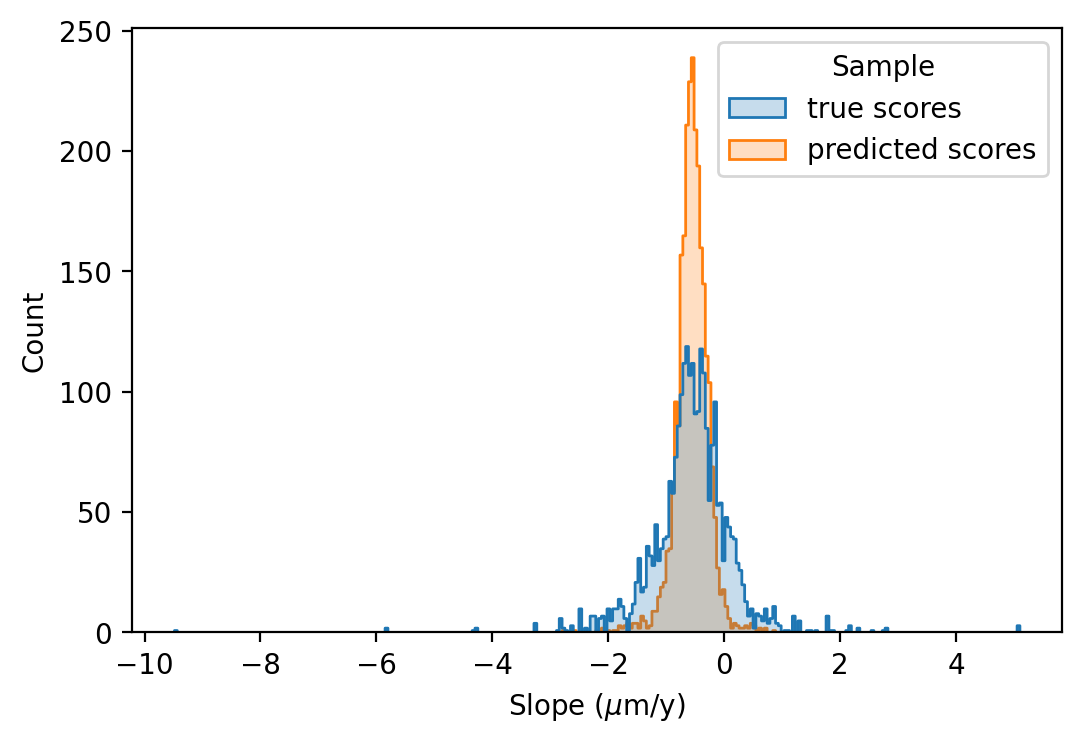

In [13]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [14]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.1824507151140317, pvalue=4.98937849632216e-38)


In [15]:
df.to_csv('predscores.csv')

In [16]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [17]:
import pandas as pd
import numpy as np

In [18]:
df = pd.read_csv('predscores.csv')

In [19]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [20]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [21]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [22]:
coefficient_of_dermination

0.38017413963393654

In [23]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [24]:
rsquared(true, pred)

0.4527104570779697

In [23]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6363938776250967, pvalue=9.068718432604108e-294)

In [24]:
scipy.stats.pearsonr(true, pred)

(0.6406520077265812, 6.324456783796106e-299)